# PROJECT: Optimization strategies for robust regression

Author: Alexandre Gramfort, Hugo Mallet, Mithuran Gajendran

## Aim:

- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.

In [1]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

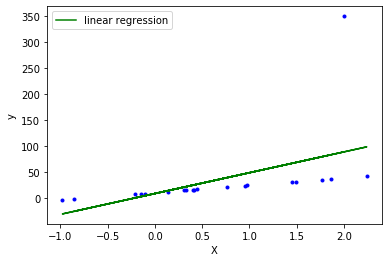

In [3]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
       noise=0, bias=10.0)

#y=y**2

# Add an outlier
X[0, 0] = 2.
y[0] = 350
# Fit the model
reg = LinearRegression()
reg.fit(X, y)

# Visualize the model
x = X[:, 0]
#print("X ", X.shape)
y_pred = reg.coef_ * x + reg.intercept_

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

The outlier (2,350) has a strong impact on the regression. It has a high leverage due to its far position.

The linear regression is too much sensistive to a "far" outlier.

One possible solution would be to exclude any outlier (or a really small percentage of outliers e.g. 1%) of the linear regression calculus, if its value makes clearly no sense. We could :
- derive the regression
- calculate the residuals
- exclude the points for which the residuals are extreme (more than three standard deviations of the residuals).

Another idea would be to change the loss: the square loss is not the best one to considerate here. It gives way too much importance to the outlier. Intuitively, one can think of using the L1-norm. 

## Part 1: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [5]:
epsilon = 1.

def huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z

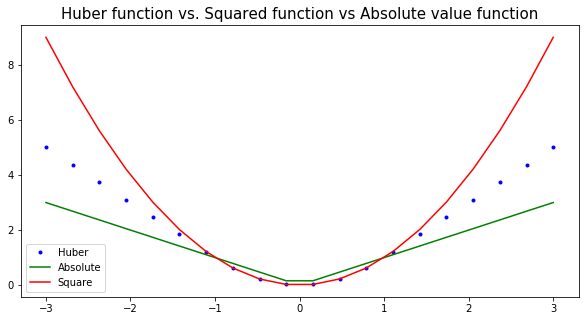

In [6]:
plt.figure(figsize=(10, 5))
x= np.linspace(-3,3,20)
plt.plot(x,huber(x,epsilon = 1),'b.',label="Huber")
plt.plot(x, np.absolute(x), 'g',label="Absolute")
plt.plot(x, np.square(x), 'r',label="Square")
plt.title("Huber function vs. Squared function vs Absolute value function", fontsize=15)
plt.legend()
plt.show()

Let's proove the convexity and smoothness of the Huber function

* **First derivative**

The huber function is differentiable by pieces on intervals  : $]-\infty, -\epsilon[$, $]-\epsilon, \epsilon[,$ and $]\epsilon, +\infty[$.

Computing the first derivative according to those intervals : 
$$
    H'_\epsilon (x) = \left\{
	\begin{aligned}
    2 \epsilon & \quad \mathrm{ x > \epsilon }\\
	2x & \quad \mathrm{ if }  -\epsilon < x < \epsilon \\
    -2 \epsilon & \quad \mathrm{ x < -\epsilon } \\
	\end{aligned}
    \right.
$$

In each cases for $x = -\epsilon$ and $x = \epsilon$, we have that the first derivative converges respectively to $-2\epsilon $ and $2\epsilon$. Thus, the **huber function is continuously differentiable on $\mathbb{R}$**.

* **Convexity**

The Huber function is differentiable on $\mathbb{R}$ and the first derivative is increasing, which gives us the convexity of the function. One can also *see* that Huber function is visually above its tangents.

* **Smoothness**

At the very minimum, the function is smooth as  it is differentiable everywhere, hence continuous.<br> More strinking, we can see that the squared value function upper bounds the Huber function.  

By computing the first derivative in the case where $|x| < \epsilon$ : 
* $|H'(x) - H'(y)|\le 2|x - y|$ 

Hence, the Lipschitz constant is $2$ and the Huber fonction is **L-smooth** with L = 2.


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Write a function that computes the gradient of the Huber loss.</li>
    </ul>
</div>

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

Let's code the gradient of huber loss, and check its validity with check_grad on the key points

minimum check grad error  0.0 maximum check grad error 1.8038248228435805e-08


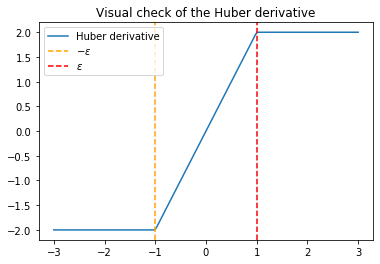

In [8]:
from scipy.optimize import check_grad
# epsilon fixed at 1.

def grad_huber(x, epsilon=epsilon):
    return 2 * np.clip(x, a_min=-epsilon, a_max=epsilon) #Les x < -epsilon == -epsilon, x> epsilon == epsilon

check = []
for i in np.linspace(-3,3,20):
    check.append(check_grad(huber, grad_huber, np.array([i])))
    
print('minimum check grad error ' , min(check), 'maximum check grad error', max(check))

# visual check of the Huber derivative, faster to understand than numbers :)
x = np.linspace(-3,3,200)
hub_grad = grad_huber(x)

plt.plot(x, hub_grad, label="Huber derivative")
plt.axvline(x=-epsilon,color='orange', linestyle='--',label="$-\epsilon$")
plt.axvline(x=epsilon,color='red', linestyle='--',label="$\epsilon$")
plt.title("Visual check of the Huber derivative")
plt.legend()
plt.show()


Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

* What optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above?

* Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$.

We have to recall the needed hypothese for each optimization strategy:

**L-BFGS:**
* $f+R$ has to be convex and twice differentiable on $\mathbb{R}$
* $f$ has to be $\mu$ strongly convex and $L-smooth$ on $\mathbb{R}^d$ and $ 0<\mu<L$

L1 is not differentiable everywhere on $\mathbb{R}$, while L2 suits those conditions.

**Proximal gradient descent:**
* f has to be convex and differentiable
* R is convex but not always differentiable
* $\nabla f$ derivable is lipschitz continuous  

The L1 and L2  are convex, they both suit the conditions.

**Gradient descent:**
* $f + R$ has to be convex.
* $f+R$ has to be differentiable

L1 is not smooth nor differentiable everywhere, while L2 suits those conditions.

**Proximal coordinate descent:**
* $f+R$ is convex
* $f$ has a Lipschitz continuous gradient
* $g$ may be nonsmooth but is separable

The L1 and L2 both suit the conditions.



**Coordinate descent:**( _Warga(1963)_ )
* $f+R$ is strictly convex
* $f+R$ is continuously differentiable
* $\exists x_{*} \in argmin_{x \in X} f+R(x)$

L1 doesn't suit those conditions as it is not continuously differentiable.


### **Application to Huber function :**

Small reminder : 
 * if f or R is not differentiable : $f+R$ is not differentiable
 * If f or R is not smooth : $f+R$ is not smooth
 
We have seen earlier that the Huber function is convex and continuously differentiable on $\mathbb{R}$

Knowing those informations : 


* $f + R1$ = (Huber fonction + L1 norm) is not differentiable everywhere but convex.
* $f + R2$ =(Huber fonction + L2 norm) is differentiable and convex.

Thus, according to our analysis, we have that : 
* **L_BFGS** algorithm can be applied to the Huber fonction only with R2 regularization as L1 norm is not differenciable everywhere.
*  **Gradient descent** algorithm can be applied with R2 regularizations.
* **Proximal gradient descent** is readily applicable with both R1 and R2 as R has to be convex but doesn't need to be always differentiable.
* **Coordinate gradient descent** : is only applicable on L2 Regularization
* **Proximal Coordinate gradient descent** : is only applicable on both L1 and L2 Regularization.

Hence, to resume :
 * **All the algorithms** mentionned above are readily applicable to L2.
 * Algorithms readily applicable for L1 are : 
     * **Proximal Gradient Descent**
     * **Proximal Coordinate Descent**

Let's apply lbfgs with R = l2 norm

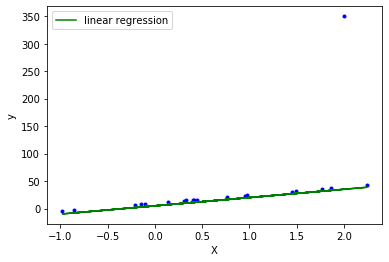

In [11]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01

def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w**2) -np.dot(X, w)- b, epsilon=epsilon)) + lbda * np.sum(w ** 2)

def grad_huber_loss(params, X, y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    N = X.shape[0]
    vect_grad = params.copy()
    vect_grad[0]=-np.sum(grad_huber(y - np.dot(X, w**2)-np.dot(X, w)-b, epsilon))/N
    vect_grad[1:]=(-np.dot(X.T, grad_huber(y - np.dot(X, w**2)-np.dot(X, w)-b, epsilon))/N)
    return vect_grad

def huber_lbfgs_l2(X, y, lbda=lbda, epsilon=epsilon):
    x0 = np.ones(X.shape[1] + 1)
    params, f, d = fmin_l_bfgs_b(func=pobj_l2, fprime=grad_huber_loss, x0=x0, args=(X, y, lbda, epsilon))
    return params, f, d

params, f, d = huber_lbfgs_l2(X,y)
b, w = params[0], params[1:]

x = X[:, 0]
y_pred = np.dot(X, w**2)+X.dot(w) + b

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()
# END TODO

## Part 2: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [12]:
def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [13]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

Let's try different algorithms with L1 and L2 norms:
* PGD
* APGD
* PCD

In [14]:
def pgd(x_init, grad, prox, step, n_iter=10000, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        x = prox(x - step * grad(x, *grad_args), step, *prox_args)
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [15]:
def prox_R2(params, reg=1.):
    params = params.copy()
    w = params[1:]
    b = params[0]
    params[1:] = w/(1+2*reg)
    return params

def prox_R1(params, reg=1.):

    params = params.copy()
    w = params[1:]
    params[1:]= np.sign(w) * np.maximum(np.absolute(w)-reg,0) #Soft thresholding
    return params

def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)

def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

def lipschitz_constant(X):
    X_svd = np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)[1]
    return (2/n_samples)*X_svd.max()**2

monitor run
(500, 100) (500,)


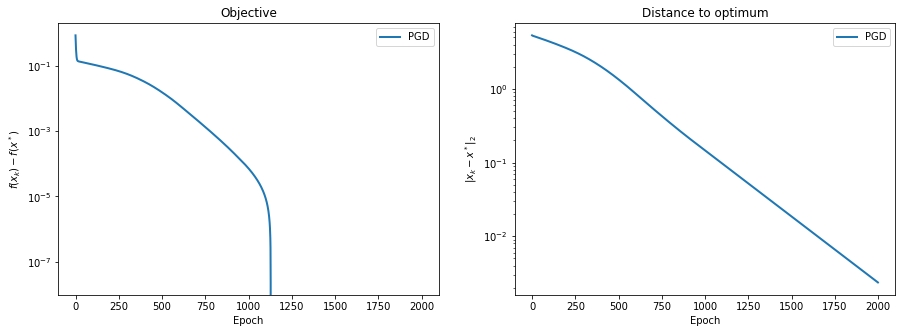

In [16]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 1
epsilon = 1
L= lipschitz_constant(X)
step = 1/L


x0 = np.zeros(X.shape[1] + 1)
x_min,  x_list = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter=10000,grad_args=(X,y,lbda,epsilon), prox_args=(lbda,))


# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, epsilon))
print("monitor run")
print(X.shape, y.shape)
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

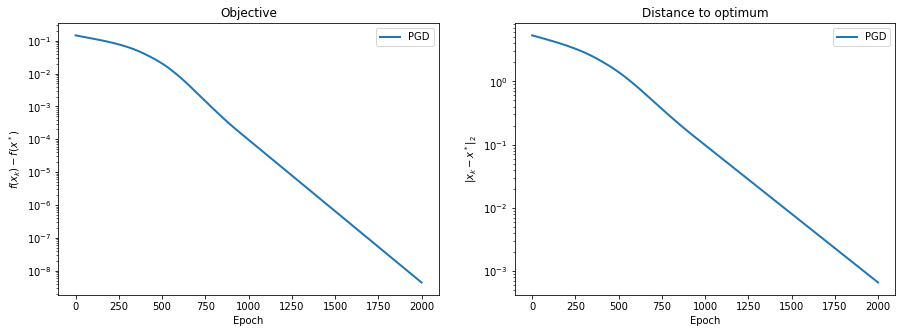

In [17]:
x_min,  x_list = pgd(x_init, grad_huber_loss, prox_l1, step, n_iter=10000,grad_args=(X,y,lbda,epsilon), prox_args=(lbda,))

# Run PGD for L1
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

In [18]:
def apgd(x_init, grad, prox, step, n_iter=10000, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        x_new = prox(y - step * grad(y, *grad_args),step, *prox_args) 
        t_new = (1+np.sqrt(1+4*t**2))/2
        y = x_new + ((t-1)/(t_new)*(x_new-x))
        x = x_new
        t = t_new
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

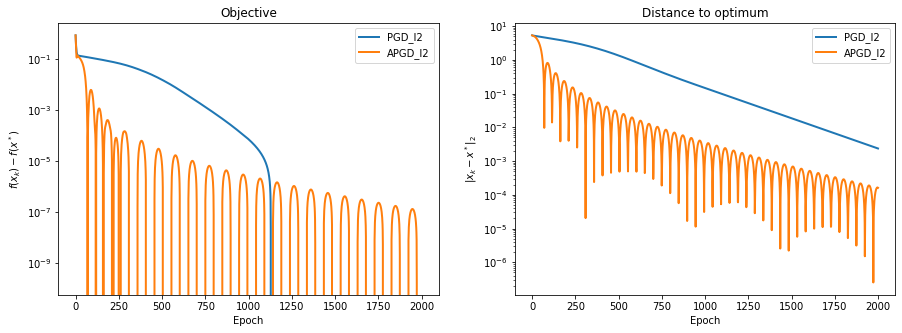

In [19]:
x_min,  x_list = apgd(x_init, grad_huber_loss, prox_l2, step, n_iter=10000,grad_args=(X,y,lbda,epsilon), prox_args=(lbda,))
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))


monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD_l2", "APGD_l2"]
plot_epochs(monitors, solvers)

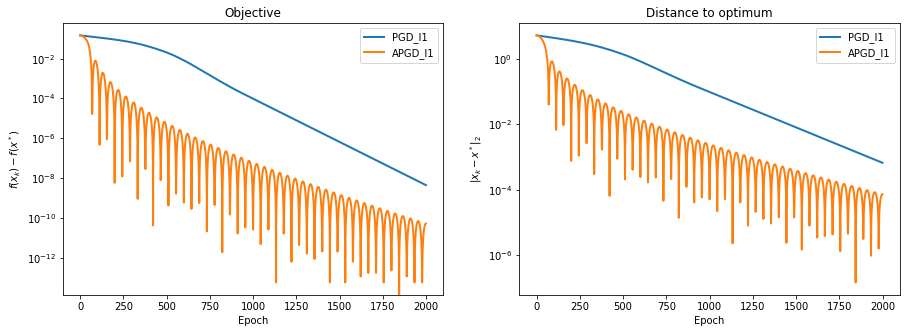

In [20]:
x_min,  x_list = apgd(x_init, grad_huber_loss, prox_l1, step, 10000,grad_args=(X,y,lbda,epsilon),
                      prox_args=(lbda,))
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min= x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=( lbda,))


monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD_l1", "APGD_l1"]
plot_epochs(monitors, solvers)

In [21]:
def grad_cd(params, j, X=X, y=y, lbda=lbda, epsilon=epsilon):
    if j==0:
        return - np.mean(grad_huber(y - np.dot(X, params[1:]) -  params[0]))
    else:
        return - np.dot(X[:,j-1], grad_huber(y - np.dot(X, params[1:]) -  params[0])) / len(X)

def pcd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):

    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        x[0] =  x[0] - step[0] * grad(x, 0, *grad_args) # b update

        for j in range(1, len(x)): # W update
            arg_prox = np.array([0,  x[j] - step[j] * grad(x, j, *grad_args)  ])
            x[j] =  prox(arg_prox, step[j], lbda = prox_args[0])[1]
            
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

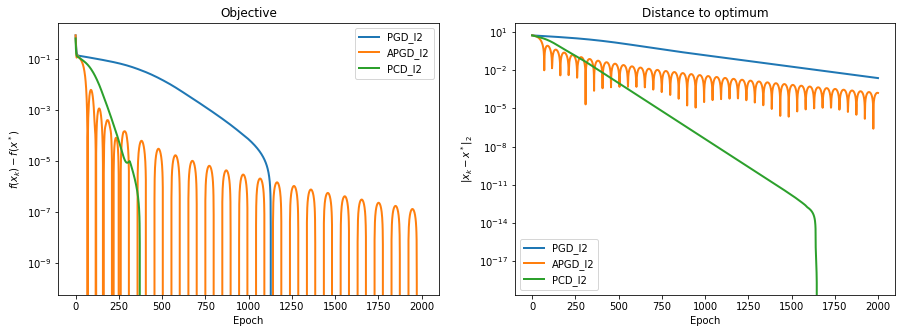

In [22]:
steps = 1/np.append(1,((2 / n_samples) * (X**2).sum(axis = 0)))
x_min, _ = pcd(x_init, grad_cd, prox_l2, steps, 10000, 1, (X, y, epsilon), (lbda,))
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l2.run(x_init, grad_cd, prox_l2, steps, n_iter, grad_args=(X, y, lbda,epsilon), prox_args=(lbda,))
monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD_l2", "APGD_l2", "PCD_l2"]
plot_epochs(monitors, solvers)

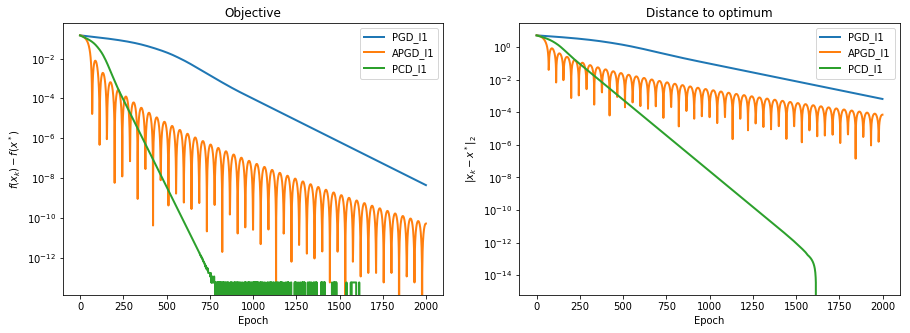

In [20]:
x_min, _ = pcd(x_init, grad_cd, prox_l1, steps, 10000, 1, (X, y, epsilon), (lbda,))
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
monitor_pcd_l1.run(x_init, grad_cd, prox_l1, steps, n_iter, grad_args=(X, y,lbda, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD_l1", "APGD_l1", "PCD_l1"]
plot_epochs(monitors, solvers)

Plot them all

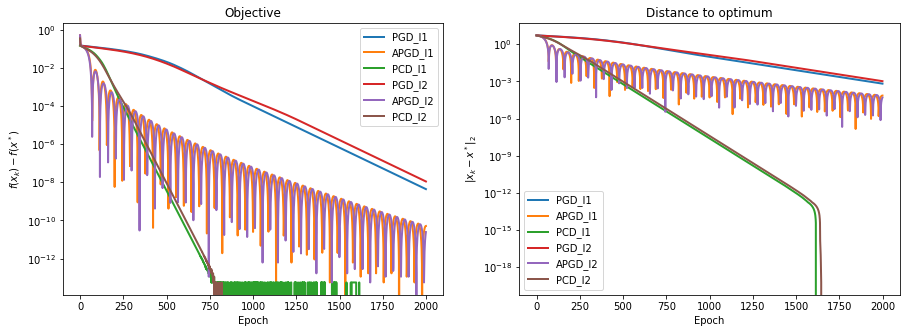

In [21]:
monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1,monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD_l1", "APGD_l1", "PCD_l1","PGD_l2", "APGD_l2", "PCD_l2"]
plot_epochs(monitors, solvers)

Now let's compare all of these algorithm

In [22]:
def plot_them_all(n_samples,n_features):
    
    X, y = make_regression(n_samples=n_samples, n_features=n_features, random_state=0,
                           noise=4.0, bias=10.0)
    n_samples, n_features = X.shape
    x_init = np.zeros(n_features + 1)
    x_init[0] = np.mean(y)
    n_iter = 2000
    lbda = 1
    epsilon = 1
    L= lipschitz_constant(X)
    step = 1/L
    
    # Run PGD for L2
    x0 = np.zeros(X.shape[1] + 1)
    x_min,  x_list = pgd(x_init, grad_huber_loss, prox_l2, step, n_iter=10000,grad_args=(X,y,lbda,epsilon), prox_args=(lbda,))
    monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, epsilon))
    monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))
    # Run PGD for L1
    x_min,  x_list = pgd(x_init, grad_huber_loss, prox_l1, step, n_iter=10000,grad_args=(X,y,lbda,epsilon), prox_args=(lbda,))
    monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
    monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))
    # Run APGD for L2
    x_min,  x_list = apgd(x_init, grad_huber_loss, prox_l2, step, n_iter=10000,grad_args=(X,y,lbda,epsilon), prox_args=(lbda,))
    monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, args=(X, y, lbda, epsilon))
    monitor_apgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                       grad_args=(X, y, epsilon), prox_args=(lbda,))
    # Run APGD for L1
    x_min,  x_list = apgd(x_init, grad_huber_loss, prox_l1, step, 10000,grad_args=(X,y,lbda,epsilon),
                          prox_args=(lbda,))
    monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min= x_min, args=(X, y, lbda, epsilon))
    monitor_apgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                       grad_args=(X, y, epsilon), prox_args=( lbda,))
    
    steps = 1/np.append(1,((2 / n_samples) * (X**2).sum(axis = 0)))
    
    # Run pcd l2
    
    x_min, _ = pcd(x_init, grad_cd, prox_l2, steps, 10000, 1, (X, y, epsilon), (lbda,))
    monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min, args=(X, y, lbda, epsilon))
    monitor_pcd_l2.run(x_init, grad_cd, prox_l2, steps, n_iter, grad_args=(X, y, lbda,epsilon), prox_args=(lbda,))
    # Run pcd L1
    x_min, _ = pcd(x_init, grad_cd, prox_l1, steps, 10000, 1, (X, y, epsilon), (lbda,))
    monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min, args=(X, y, lbda, epsilon))
    monitor_pcd_l1.run(x_init, grad_cd, prox_l1, steps, n_iter, grad_args=(X, y,lbda, epsilon), prox_args=(lbda,))
    #PLOT
    monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1,monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
    solvers = ["PGD_l1", "APGD_l1", "PCD_l1","PGD_l2", "APGD_l2", "PCD_l2"]
    plot_epochs(monitors, solvers)


### (Initial problem) : Samples (500)   Features (100) : 

* PGD L2 has the slowest convergence speed.
* PGD L1's performances are close to PGD L2. However, it tends to become faster till 750 epochs and almost converges up to $10^{-8}$ from the objective after 2000 epochs whereas PGD L2 struggles to keep up.
* APGD L1 and APGD L2 have quite similar performances. They both converges quickly at first but are then "catched up" after 250 by PCD methods. 

**PCD solvers are best suited for this problem.** Both methods reach the optimum after around 1600 epoch whereas other methods are far from those results after 2000 epochs. 
* PCD L1 converges a bit faster than PCD L2. It seems to be the best solver for this problem.

**Our suggestion : Using PCD solver with L1 regularization for this problem.**


### High number of Samples (1000),  Features  100: 


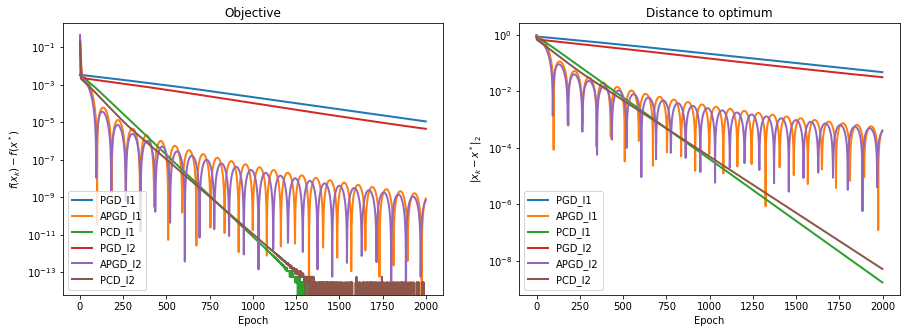

In [23]:
plot_them_all(1000,100)

* PGD L1 and PGD L2 both start to converge quickly but slow down after 100 epochs.
* PGD L1 has the lowest convergence speed.
* PGD L2 converges a bit faster than PGD L1 but both have still a low convergence rate compared to other solvers.
* PCD L1 and PCD L2 both converge rapidly to the objective.
* Although PCD L2 is faster than PCD L1 at first, PCD L1 finally converges quicker to the optimum and the objective than PCD L2. However, we can observe some erratic bouncings while getting closer to the objective.
* APGD L1 APGD L2 both have almost the same convergence speed. However, we can observe that APGD L1's bounces are less precise (larger) than APGD L2's, which could be the cause of APGD's convergence to the objective slowing down. 

Again, **PCD L1 seems to be the best solver for this problem with High samples**.

### Low Number of Samples 100  - Features 100 : 

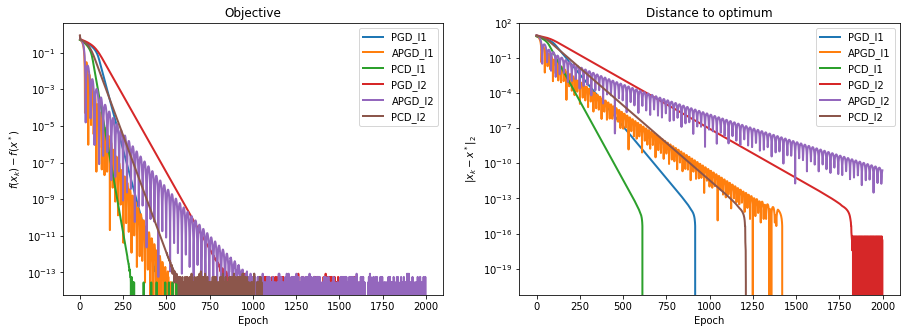

In [24]:
plot_them_all(100,100)

* PGD L2 has the lowest convergence speed at first but finally converges quicker than APGD L2
* PGD L1 is much more effective than with a high number of samples. In fact, we can observe that although PGD L1 strugles at first, it starts being more effective after 250 epochs. Thus, PGD L1 ends up by converging faster than all the solvers but PCD L1.
* PCD L1 has the best convergence rate. 
* Although APGD L2 is faster than other solver, it slows down and is finally less effective compared to other solvers after 2000 epochs.  
* APGD L1 struggles with the same issue as APGD L2 but still converges faster. However, it is still not the best solution.
* PCD L2 converges to the objective slowly compared to APGD L1, PCD L1 and PGD L1. 
* PCD L1 has the best convergence rate. Although it starts slower than APGD L1 and L2, it quickly catches up by converging to the optimum almost linearly.

We can observe that in those conditions, L1 regularization are much more effective than L2.

**Although PGD L1 has really good results, PCD L1 is still the best solver in this case.**

### Samples : 500 - Low Number of Features 10 : 

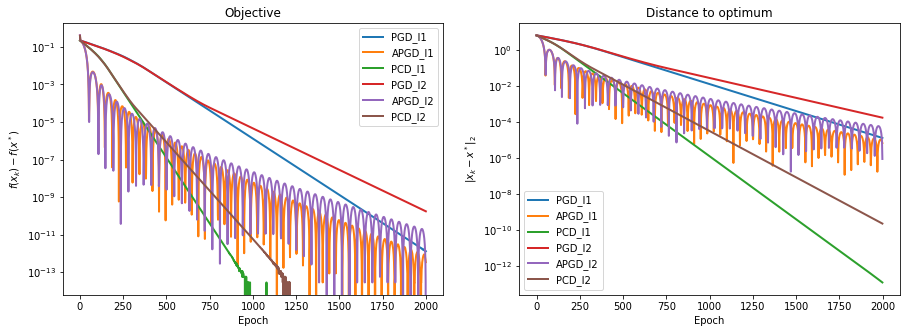

In [25]:
plot_them_all(500,10)

* PGD L2 has the lowest convergence speed
* PGD L1 converges slowly at first but gets faster after 750 epochs till catching up with APGD L1 and L2 after 2000 epochs.
* PCD L1 starts slowly but convergence to the objectve increases linearly till reaching the objective before the other solvers.
* APGD L1 and L2 both start faster than other methods but keep slowing down and struggle to converge.

**PCD L1 seems to be the best solution.** 

### High number of Samples 2000 - Low number of Features : 3


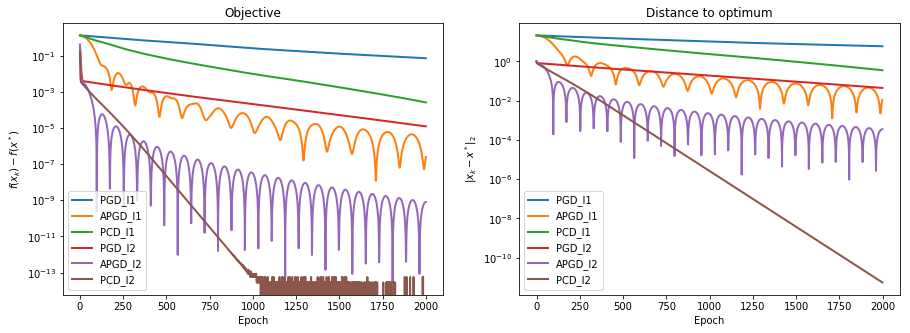

In [26]:
plot_them_all(2000,3)

* PGD L1 has the lowest convergence speed
* PCD L1's performance seems to be severely impacted by the low number of features. Thus, although it converges faster than PGD L1, its convergence rate is clearly behind the other solvers.
* APGD L1 is starts slowly compared to L2 solvers. However, it manages to converge faster than PGD L2 in the end.
* APGD L2 starts faster than the other solvers and finally converges quicker to the optimum than other methods but the PCD L2.
* PCD L2 is the quickest to converge. It quickly catches up with the APGD L2 which had a fast start.

**We can observe that the only solver managing to get along with a really low number of features is the PCD_L2 which gets the closer to the objective (almost $10^{-12}$) after 2000 epochs.**

# Our conclusion : 

According to our results, we can observe that :
   * In average, using a PCD solver is a good solution to our problems.
        * In general, using the PCD L1 solver is the best solution to our problem. However, while using a really high number of samples compared to the number of features, the PCD L1 will become ineffective and we will rather use the PCD L2 solver.
         
   * With a low number of samples, solvers using L1 regularization will be more effective that solvers with L2 regularization.


# Part 3: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [28]:
import pandas as pd
df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

,LNOx,LNOxEm,sqrtWS
193,4.457250,5.536489,0.856446
194,4.151827,5.513000,1.016612
195,3.834061,4.886994,1.095445
196,4.172848,5.138912,1.354068
197,4.322807,5.666518,1.204159


Now let's extract `X` and `y`

In [29]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx']
X.shape, y.shape

((8088, 2), (8088,))

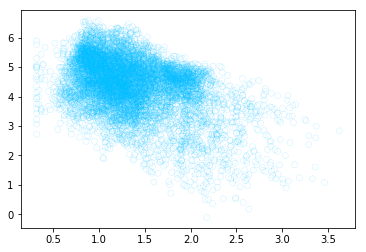

In [30]:
plt.scatter(X[:, 1], y,facecolors='none', edgecolors='deepskyblue',linewidths=0.1)

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

In [31]:
from sklearn.base import BaseEstimator, RegressorMixin


class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1.,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        

        
        x_init = np.zeros(n_features + 1)
        x_init[0] = np.mean(y)
        L = lipschitz_constant(X)
        step = 1. / L        
        
        if self.penalty == "l1":
            prox = "prox_l1"
        else:
            prox = "prox_l2"
            
        if self.solver=='pcd':
            step = 1/np.append(1,((2 / n_samples) * (X**2).sum(axis = 0)))
            grad = grad_cd
        else:
            grad = grad_huber_loss
        
        prox = globals()[prox]
        solver = globals()[self.solver]
        x,_ = solver(x_init=x_init, grad=grad, prox=prox, step=step, n_iter=self.max_iter, store_every=1, grad_args=(X, y,self.lbda, self.epsilon), prox_args=(self.lbda,))

            

        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self


    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using negative mean absolute error
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))


for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l1', max_iter=1000, solver=solver)
    clf.epsilon
    clf.fit(X, y)
    print('Solver with L1: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   MAE : 0.67331
Solver with L2: apgd   	-   MAE : 0.56706
Solver with L2: pcd   	-   MAE : 0.57371
Solver with L1: pgd   	-   MAE : 0.70951
Solver with L1: apgd   	-   MAE : 0.71306
Solver with L1: pcd   	-   MAE : 0.71309


Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).


In [32]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from time import time


for penalty in ["l1","l2"]:
    for solver in ['pgd', 'apgd', 'pcd']:
        t0 = time()
        clf = HuberRegressor(lbda=1., penalty=penalty, max_iter=1000, solver=solver)
        clf.fit(X, y)
        print('Our solver with %s : %s \t-\t CV_Score : %s \t-\t Time:%s' % (penalty,solver, -np.mean(cross_val_score(clf,X,y,cv=5, scoring='neg_mean_absolute_error')), time() - t0))
        if penalty=="l1":
            reg = linear_model.Lasso(alpha=1/2.) 
            reg.fit(X, y)
            t0 = time()
            print('Scikit-learn Lasso : %s \t-\t CV_Score : %s \t-\t Time:%s \n' % (solver, -np.mean(cross_val_score(reg,X,y,scoring='neg_mean_absolute_error',cv=5)), time() - t0))
        else:
            reg = linear_model.Ridge(alpha=X.shape[0]) 
            reg.fit(X, y)
            t0 = time()
            print('Scikit-learn Ridge : %s \t-\t CV_Score : %s \t-\t Time:%s \n' % (solver, -np.mean(cross_val_score(reg,X,y,scoring='neg_mean_absolute_error',cv=5)), time() - t0))

Our solver with l1 : pgd 	-	 CV_Score : 0.7155235214906808 	-	 Time:30.464139699935913
Scikit-learn Lasso : pgd 	-	 CV_Score : 0.666884871055554 	-	 Time:0.013925313949584961 

Our solver with l1 : apgd 	-	 CV_Score : 0.7184975375194039 	-	 Time:29.11737060546875
Scikit-learn Lasso : apgd 	-	 CV_Score : 0.666884871055554 	-	 Time:0.01100301742553711 

Our solver with l1 : pcd 	-	 CV_Score : 0.7186144852641092 	-	 Time:38.2551646232605
Scikit-learn Lasso : pcd 	-	 CV_Score : 0.666884871055554 	-	 Time:0.013950824737548828 

Our solver with l2 : pgd 	-	 CV_Score : 0.6768781006575008 	-	 Time:27.337288856506348
Scikit-learn Ridge : pgd 	-	 CV_Score : 0.5796194046243801 	-	 Time:0.02308940887451172 

Our solver with l2 : apgd 	-	 CV_Score : 0.5815407400809142 	-	 Time:26.95660376548767
Scikit-learn Ridge : apgd 	-	 CV_Score : 0.5796194046243801 	-	 Time:0.010002613067626953 

Our solver with l2 : pcd 	-	 CV_Score : 0.5844400791064297 	-	 Time:37.34929537773132
Scikit-learn Ridge : pcd 	-	 

* Unsurprisingly, our solvers have slightly lower Cv_Score. 
* The only issue happens with the PGD l2. The CV_Score is quite different than the Scikit-learn model. We assume that this is due to the lack of iterations. Indeed, it was the slowest to converge, and may have needed more time to get to an optimal score.
* The running time performances ont the other hand, are really bad: around x2000 times slower than scikit learn's model.



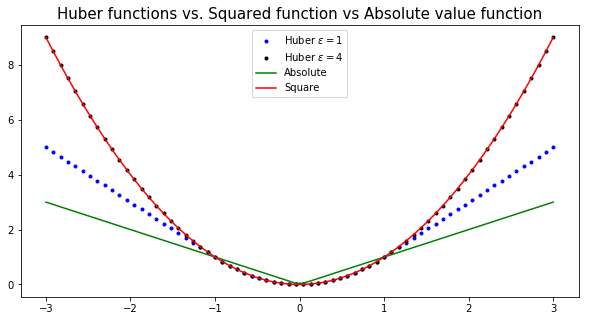

In [33]:
plt.figure(figsize=(10, 5))
x= np.linspace(-3,3,70)
plt.plot(x,huber(x,epsilon = 1),'b.',label="Huber $\epsilon=1$")
plt.plot(x,huber(x,epsilon = 4),'k.',label="Huber $\epsilon=4$")
plt.plot(x, np.absolute(x), 'g',label="Absolute")
plt.plot(x, np.square(x), 'r',label="Square")
plt.title("Huber functions vs. Squared function vs Absolute value function", fontsize=15)
plt.legend()
plt.show()

Changing epsilon size will actually change the proportion of the dataset penalized by  l1 or l2. We can clearly show for x between -3,3 that Huber $\epsilon=4$ is the square function. In other words, the impact of Huber depend of where the majority of the data is. Here it is centred around (1,5)

In [34]:
for eps in [0.1,1,4,10,100]:
    print("\nEpsilon : %s"%(eps))
    for penalty in ["l2"]:
        for solver in ['pgd', 'apgd', 'pcd']:
            t0 = time()
            clf = HuberRegressor(lbda=1., penalty=penalty, max_iter=1000, solver=solver, epsilon=eps)
            clf.fit(X, y)
            print('Our solver with %s : %s \t-\t CV_Score : %s \t-\t Time:%s' % (penalty,solver, -np.mean(cross_val_score(clf,X,y,cv=5, scoring='neg_mean_absolute_error')), time() - t0))
            if penalty=="l2":
                reg = linear_model.Ridge(alpha=X.shape[0])
                reg.fit(X, y)
                t0 = time()
                print('Scikit-learn Ridge : %s \t-\t CV_Score : %s \t-\t Time:%s \n' % (solver, -np.mean(cross_val_score(reg,X,y,scoring='neg_mean_absolute_error',cv=5)), time() - t0))


Epsilon : 0.1
Our solver with l2 : pgd 	-	 CV_Score : 0.7044204334825424 	-	 Time:27.236588716506958
Scikit-learn Ridge : pgd 	-	 CV_Score : 0.5796194046243801 	-	 Time:0.012000322341918945 

Our solver with l2 : apgd 	-	 CV_Score : 0.6854565090105199 	-	 Time:44.54303574562073
Scikit-learn Ridge : apgd 	-	 CV_Score : 0.5796194046243801 	-	 Time:0.021094560623168945 

Our solver with l2 : pcd 	-	 CV_Score : 0.5844400791064297 	-	 Time:72.26124978065491
Scikit-learn Ridge : pcd 	-	 CV_Score : 0.5796194046243801 	-	 Time:0.01765727996826172 


Epsilon : 1
Our solver with l2 : pgd 	-	 CV_Score : 0.6768781006575008 	-	 Time:47.22869682312012
Scikit-learn Ridge : pgd 	-	 CV_Score : 0.5796194046243801 	-	 Time:0.018949031829833984 

Our solver with l2 : apgd 	-	 CV_Score : 0.5815407400809142 	-	 Time:49.46023964881897
Scikit-learn Ridge : apgd 	-	 CV_Score : 0.5796194046243801 	-	 Time:0.014999151229858398 

Our solver with l2 : pcd 	-	 CV_Score : 0.5844400791064297 	-	 Time:68.175983428955